In [10]:
import torch 
import torch.nn as nn 
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize 

import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import os
from tqdm import tqdm 
tqdm.pandas()
from collections import Counter
import re
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("../13.Coronavirus_tweet_classification/archive/Corona_NLP_train.csv", encoding='ISO-8859-1')
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [12]:
df_related = df[['OriginalTweet', 'Sentiment']]
df_related.head(4)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive


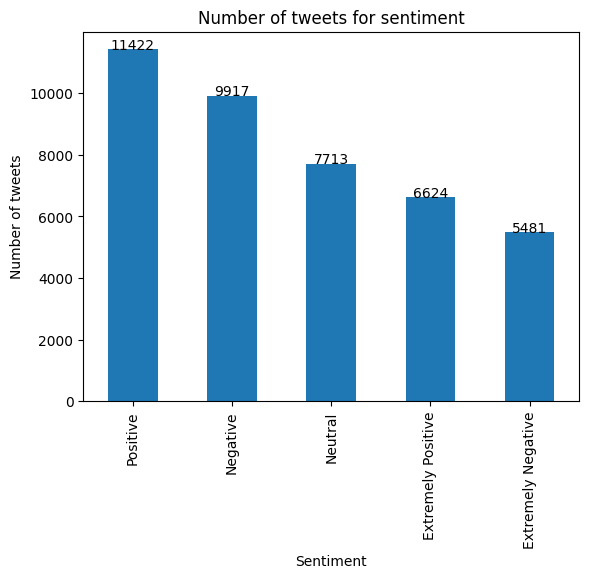

In [13]:
value_counts = df_related.Sentiment.value_counts()
ax = value_counts.plot(kind = 'bar')
plt.xlabel("Sentiment")
plt.ylabel('Number of tweets')
plt.title("Number of tweets for sentiment")

for i, count in enumerate(value_counts):
    ax.text(i, count + 0.1, str(count), ha='center')
plt.show()

In [14]:
le = LabelEncoder()

df_related['sent_encoded'] = le.fit_transform(df_related['Sentiment'])
df_related.head(4)

/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_24346/802176687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_related['sent_encoded'] = le.fit_transform(df_related['Sentiment'])


,OriginalTweet,Sentiment,sent_encoded
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3
1,advice Talk to your neighbours family to excha...,Positive,4
2,Coronavirus Australia: Woolworths to give elde...,Positive,4
3,My food stock is not the only one which is emp...,Positive,4


In [15]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('English'))


def remove_hyperlinks(text):
    return re.sub(r'http\S+', ' ', text)

def remove_punctuation(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\,\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', '', text)

def rm_html_tags(text):
    text = re.sub(r'<.*?>', '', text)
    return re.sub(r'<br />', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)  # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)  # remove double whitespaces
    return s

def remove_integers(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub('\s+', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)


def clean_pipeline(text):
    text = text.lower()
    no_link = remove_hyperlinks(text)
    no_html = rm_html_tags(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = remove_punctuation(space_punct)
    no_number = remove_integers(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    #spell_corrected = spell_correction(no_emoji)
    return no_nonasci


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshayarravarapu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harshayarravarapu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harshayarravarapu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/harshayarravarapu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
df_related['OriginalTweet'] = df_related['OriginalTweet'].progress_apply(clean_pipeline)


100%|██████████| 41157/41157 [00:00<00:00, 47841.12it/s]
/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_24346/3899655592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_related['OriginalTweet'] = df_related['OriginalTweet'].progress_apply(clean_pipeline)


In [19]:
def tokenize_words(text):
    # Tokenizes the text into list of tokens(words)
    # "go until jurong point crazy" --> "go", "until","jurong", "point", "crazy",
    return word_tokenize(text)

def remove_stopwords(text):
    ## Remove stopwords such as is am it there
    return [word for word in text if word not in stop_words]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in text:
        pos_tag = nltk.pos_tag([word])[0][1][0].upper()
        wordnet_pos = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}.get(pos_tag, wordnet.NOUN)
        # Lemmatize the word with the specified POS tag
        lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmas.append(lemma)
    ## Lemmatize words like running --> run
    # make sure lemmas does not contains stopwords
    return remove_stopwords(lemmas)



## Convert words 
def preprocess_pipeline(text):
    tokens = tokenize_words(text) ## --> Convert words into tokens
    no_stopwords = remove_stopwords(tokens) ## --> Remove stopwords before lemmatizing
    lemmas = lemmatize(no_stopwords)## --> lemmatize the words
    return ' '.join(lemmas)

In [20]:
df_related['OriginalTweet'] = df_related['OriginalTweet'].apply(preprocess_pipeline)

/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_24346/3570962251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_related['OriginalTweet'] = df_related['OriginalTweet'].apply(preprocess_pipeline)


In [ ]:
tweets = df_related['OriginalTweet'].values
# merge into single variable, separated by whitespaces
words = ' '.join(tweets)
# obtain list of words
words = words.split()
# build vocabulary
counter = Counter(words)
# only keep top 2000 words
vocab = sorted(counter, key=counter.get, reverse=True)[:2000]
int2word = dict(enumerate(vocab, 2))
int2word[0] = '<PAD>'
int2word[1] = '<UNK>'
word2int = {word: id for id, word in int2word.items()}

In [38]:
tweets_enc = [[word2int[word] if word in word2int else '<UNK>' for word in tweet] for tweet in tqdm(tweets, desc = 'encoding')]

encoding: 100%|██████████| 41157/41157 [00:00<00:00, 52328.44it/s] 
